# **Importer les Bibliothèques et Initialiser Spark**

In [11]:
import sys
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [12]:
spark = SparkSession.builder \
    .appName("Data Processing dans catalogue csv") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()
print("Session Spark initialisée avec succès.")


Session Spark initialisée avec succès.


# **Charger les données depuis le fichier Hive**

In [13]:
spark.sql("USE concessionnaire")
catalogue_df = spark.sql("SELECT * FROM catalogue_table")
catalogue_df.show(20)

+--------------------+-------+-----------+----------+--------+--------+----------------+--------+--------+---------+
|                  id|couleur|   longueur|    marque|nbplaces|nbportes|             nom|occasion|    prix|puissance|
+--------------------+-------+-----------+----------+--------+--------+----------------+--------+--------+---------+
|c8d21104-e23a-4ba...|  rouge|     longue|   Renault|       7|       5|     Espace 2.0T|    true| 21245.0|      165|
|cf92cea0-b3e0-4df...|   gris|    moyenne|Volkswagen|       5|       5|  New Beatle 1.8|   false| 26630.0|      110|
|0ede2d5f-39c0-466...|   bleu|très longue|       BMW|       5|       5|              M5|    true| 66360.0|      507|
|67c50996-af5c-4ca...|  rouge|très longue|    Nissan|       5|       5|   Maxima 3.0 V6|   false| 30000.0|      200|
|072b0696-d41c-435...|   noir|très longue|  Mercedes|       5|       5|            S500|   false|101300.0|      306|
|b0f89c6b-2bca-4db...|   gris|    moyenne|Volkswagen|       5|  

# **Renommer et Créer les Colonnes Nécessaires**

In [14]:
# Renommer la colonne 'nom' en 'modele_old' et créer les colonnes manquantes
catalogue_df = catalogue_df.withColumnRenamed("nom", "modele_old") \
    .withColumnRenamed("puissance", "unified_horse_power") \
    .withColumnRenamed("nbPlaces", "nbplaces") \
    .withColumnRenamed("nbPortes", "nbportes") \
    .withColumn("modele", F.lit(None)) \
    .withColumn("modele_detail", F.lit(None))

catalogue_df.show(5)


+--------------------+-------+-----------+----------+--------+--------+--------------+--------+--------+-------------------+------+-------------+
|                  id|couleur|   longueur|    marque|nbplaces|nbportes|    modele_old|occasion|    prix|unified_horse_power|modele|modele_detail|
+--------------------+-------+-----------+----------+--------+--------+--------------+--------+--------+-------------------+------+-------------+
|c8d21104-e23a-4ba...|  rouge|     longue|   Renault|       7|       5|   Espace 2.0T|    true| 21245.0|                165|  NULL|         NULL|
|cf92cea0-b3e0-4df...|   gris|    moyenne|Volkswagen|       5|       5|New Beatle 1.8|   false| 26630.0|                110|  NULL|         NULL|
|0ede2d5f-39c0-466...|   bleu|très longue|       BMW|       5|       5|            M5|    true| 66360.0|                507|  NULL|         NULL|
|67c50996-af5c-4ca...|  rouge|très longue|    Nissan|       5|       5| Maxima 3.0 V6|   false| 30000.0|                200|

# **Nettoyer l'Encodage**

In [15]:
# Nettoyer l'encodage dans les colonnes 'marque' et 'modele_old'
catalogue_df = catalogue_df.withColumn("marque", F.regexp_replace(F.col("marque"), "Ã©", "é")) \
                           .withColumn("modele_old", F.regexp_replace(F.col("modele_old"), "Ã©", "é"))

catalogue_df.show(5)

+--------------------+-------+-----------+----------+--------+--------+--------------+--------+--------+-------------------+------+-------------+
|                  id|couleur|   longueur|    marque|nbplaces|nbportes|    modele_old|occasion|    prix|unified_horse_power|modele|modele_detail|
+--------------------+-------+-----------+----------+--------+--------+--------------+--------+--------+-------------------+------+-------------+
|c8d21104-e23a-4ba...|  rouge|     longue|   Renault|       7|       5|   Espace 2.0T|    true| 21245.0|                165|  NULL|         NULL|
|cf92cea0-b3e0-4df...|   gris|    moyenne|Volkswagen|       5|       5|New Beatle 1.8|   false| 26630.0|                110|  NULL|         NULL|
|0ede2d5f-39c0-466...|   bleu|très longue|       BMW|       5|       5|            M5|    true| 66360.0|                507|  NULL|         NULL|
|67c50996-af5c-4ca...|  rouge|très longue|    Nissan|       5|       5| Maxima 3.0 V6|   false| 30000.0|                200|

# **Séparer 'modele' et 'modele_detail'**

In [16]:
# Séparer les colonnes 'modele' et 'modele_detail' à partir de 'modele_old'
catalogue_df = catalogue_df.withColumn(
    "modele",
    F.when(F.col("modele_old").rlike(r"^\S+\s+\d"),
           F.regexp_extract(F.col("modele_old"), r"^(\S+)", 1))
    .otherwise(F.regexp_extract(F.col("modele_old"), r"^(\S+\s\S+)", 1))
)
catalogue_df = catalogue_df.withColumn(
    "modele_detail",
    F.when(F.col("modele_old").rlike(r"^\S+\s+\d"),
           F.regexp_extract(F.col("modele_old"), r"^\S+\s+(.*)", 1))
    .otherwise(F.regexp_extract(F.col("modele_old"), r"^\S+\s+\S+\s+(.*)", 1))
)
catalogue_df = catalogue_df.withColumn("modele", F.when(F.col("modele") == "", F.col("modele_old")).otherwise(F.col("modele")))

catalogue_df.show(5)


+--------------------+-------+-----------+----------+--------+--------+--------------+--------+--------+-------------------+----------+-------------+
|                  id|couleur|   longueur|    marque|nbplaces|nbportes|    modele_old|occasion|    prix|unified_horse_power|    modele|modele_detail|
+--------------------+-------+-----------+----------+--------+--------+--------------+--------+--------+-------------------+----------+-------------+
|c8d21104-e23a-4ba...|  rouge|     longue|   Renault|       7|       5|   Espace 2.0T|    true| 21245.0|                165|    Espace|         2.0T|
|cf92cea0-b3e0-4df...|   gris|    moyenne|Volkswagen|       5|       5|New Beatle 1.8|   false| 26630.0|                110|New Beatle|          1.8|
|0ede2d5f-39c0-466...|   bleu|très longue|       BMW|       5|       5|            M5|    true| 66360.0|                507|        M5|             |
|67c50996-af5c-4ca...|  rouge|très longue|    Nissan|       5|       5| Maxima 3.0 V6|   false| 3000

# **Réorganiser les Colonnes et Enregistrer**

In [17]:
# Réordonner les colonnes et enregistrer le résultat dans Hive
columns_order = ["marque", "modele", "modele_detail", "unified_horse_power", "longueur", "nbplaces",
                 "nbportes", "couleur", "occasion", "prix"]
catalogue_df = catalogue_df.select(columns_order)

catalogue_df.write.mode("overwrite").saveAsTable("catalogue_table_processed")
print("Enregistrement dans Hive effectué avec succès.")
catalogue_df.show(20)

Enregistrement dans Hive effectué avec succès.
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+
|    marque|    modele|modele_detail|unified_horse_power|   longueur|nbplaces|nbportes|couleur|occasion|    prix|
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+
|   Renault|    Espace|         2.0T|                165|     longue|       7|       5|  rouge|    true| 21245.0|
|Volkswagen|New Beatle|          1.8|                110|    moyenne|       5|       5|   gris|   false| 26630.0|
|       BMW|        M5|             |                507|très longue|       5|       5|   bleu|    true| 66360.0|
|    Nissan|    Maxima|       3.0 V6|                200|très longue|       5|       5|  rouge|   false| 30000.0|
|  Mercedes|      S500|             |                306|très longue|       5|       5|   noir|   false|101300.0|
|Volkswagen|New Beatle|          1.8|    

# **Statistiques de Base sur les Données des Véhicules**

In [18]:
# Calcul des statistiques de base sur les colonnes pertinentes
statistiques_df = catalogue_df.describe().show()

+-------+------+------------------+------------------+-------------------+-----------+------------------+------------------+-------+------------------+
|summary|marque|            modele|     modele_detail|unified_horse_power|   longueur|          nbplaces|          nbportes|couleur|              prix|
+-------+------+------------------+------------------+-------------------+-----------+------------------+------------------+-------+------------------+
|  count|  2430|              2430|              2430|               2430|       2430|              2430|              2430|   2430|              2430|
|   mean|  NULL|            508.15|1.6235294117647057| 157.59259259259258|       NULL| 5.222222222222222| 4.814814814814815|   NULL|26668.055555555555|
| stddev|  NULL|500.24149503210475|0.3155574942598481|   90.4020493895319|       NULL|0.6286687300714241|0.5798406485524593|   NULL|19018.724104454064|
|    min|  Audi|              1007|                  |                 55|     courte|  

# **Distribution de la Puissance des Véhicules**

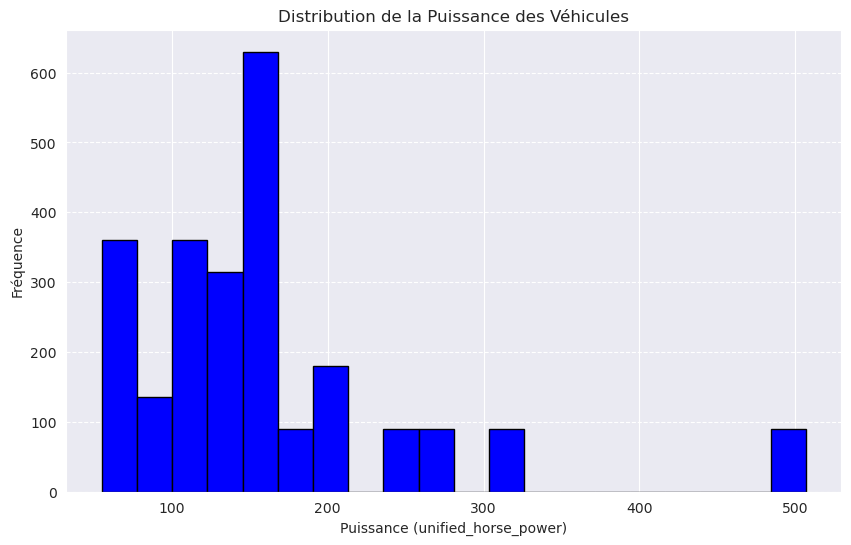

In [19]:
# Extraire les valeurs de la colonne 'unified_horse_power' pour une visualisation avec Matplotlib
horsepower_data = catalogue_df.select("unified_horse_power").rdd.flatMap(lambda x: x).collect()

# Visualiser la distribution
plt.figure(figsize=(10, 6))
plt.hist(horsepower_data, bins=20, color='blue', edgecolor='black')
plt.xlabel("Puissance (unified_horse_power)")
plt.ylabel("Fréquence")
plt.title("Distribution de la Puissance des Véhicules")
plt.grid(axis='y', linestyle='--')
plt.show()

# **Répartition des Véhicules par Nombre de Places**

+--------+-----+
|nbplaces|count|
+--------+-----+
|       5| 2160|
|       7|  270|
+--------+-----+


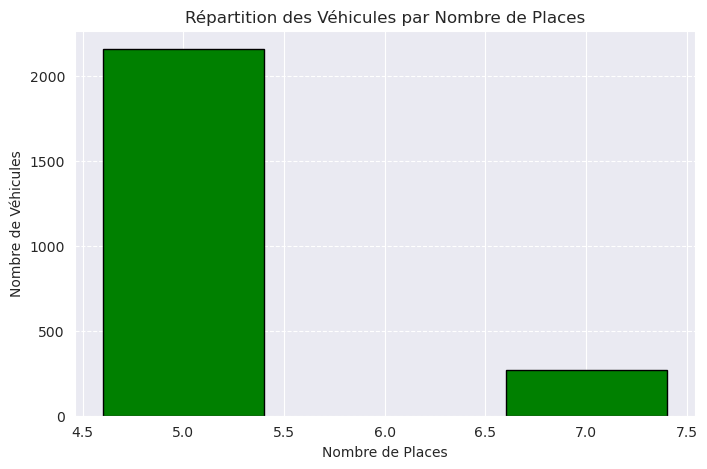

In [20]:
places_df = catalogue_df.groupBy("nbplaces").count()
places_df.show()

# Visualiser la répartition avec Matplotlib
places_data = places_df.rdd.map(lambda row: (row['nbplaces'], row['count'])).collect()
places, counts = zip(*places_data)

plt.figure(figsize=(8, 5))
plt.bar(places, counts, color='green', edgecolor='black')
plt.xlabel("Nombre de Places")
plt.ylabel("Nombre de Véhicules")
plt.title("Répartition des Véhicules par Nombre de Places")
plt.grid(axis='y', linestyle='--')
plt.show()

In [21]:
# **Analyse des Prix des Véhicules (Boxplot par Marque)**

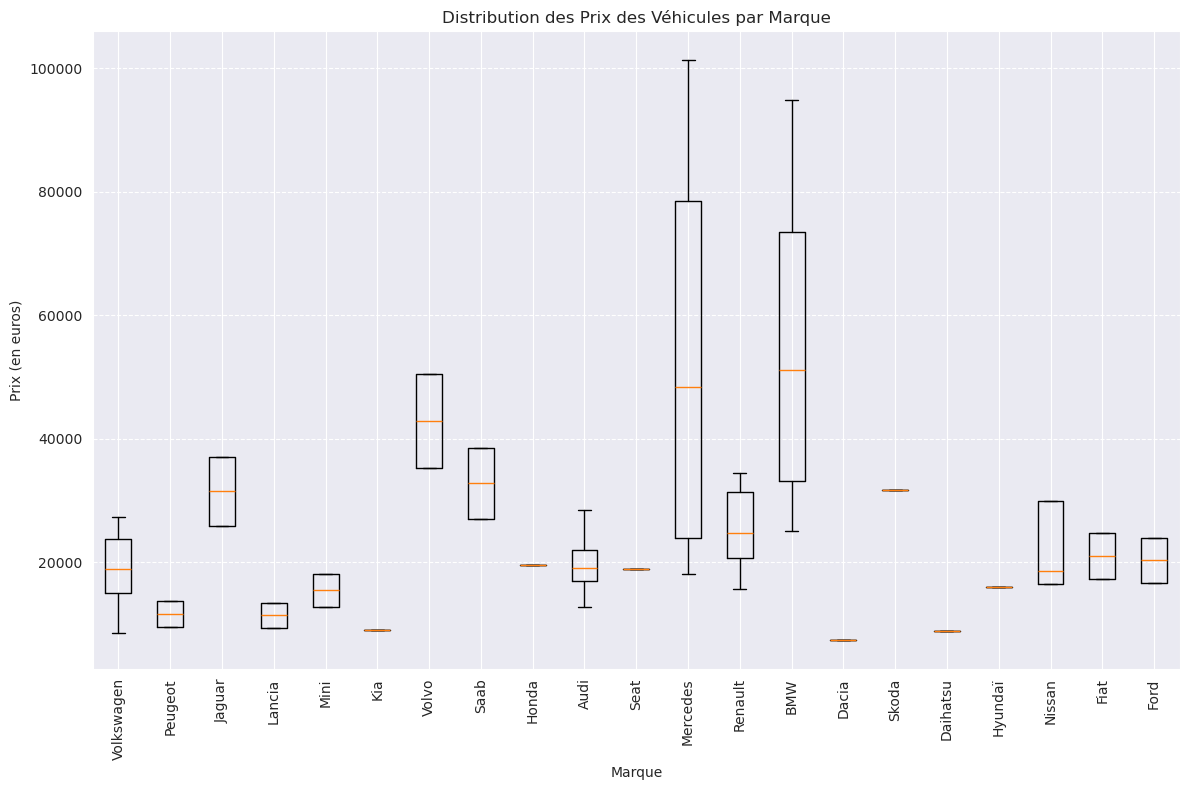

In [22]:
# Préparer les données pour un boxplot
prix_data = catalogue_df.select("marque", "prix").groupBy("marque").agg(F.collect_list("prix").alias("prix_list")).toPandas()

# Visualisation avec Matplotlib
plt.figure(figsize=(12, 8))
plt.boxplot(prix_data['prix_list'], labels=prix_data['marque'], showfliers=False)
plt.xlabel("Marque")
plt.ylabel("Prix (en euros)")
plt.title("Distribution des Prix des Véhicules par Marque")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# **Relation entre la Puissance et le Prix des Véhicules**


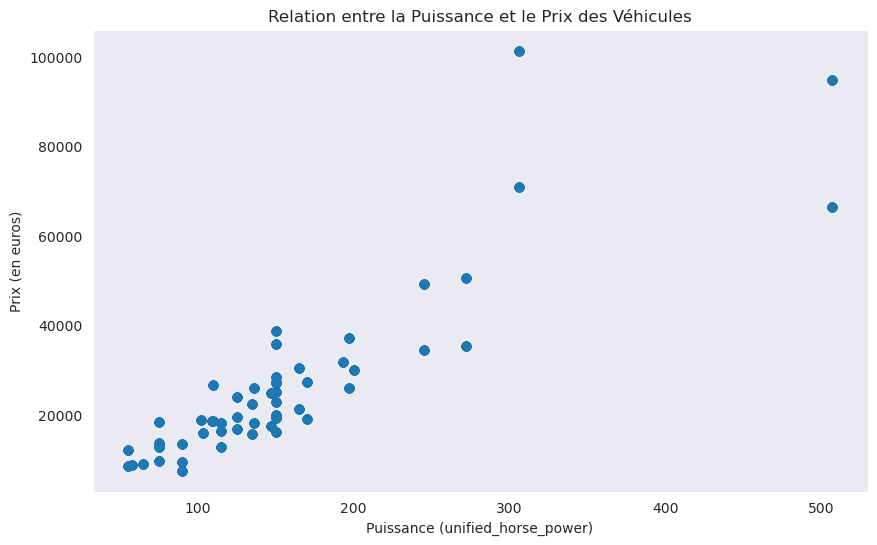

In [23]:
# Extraire les valeurs de 'unified_horse_power' et 'prix'
data = catalogue_df.select("unified_horse_power", "prix").rdd.map(lambda row: (row['unified_horse_power'], row['prix'])).collect()
horsepower, prix = zip(*data)

# Visualiser la relation entre la puissance et le prix
plt.figure(figsize=(10, 6))
plt.scatter(horsepower, prix, alpha=0.6)
plt.xlabel("Puissance (unified_horse_power)")
plt.ylabel("Prix (en euros)")
plt.title("Relation entre la Puissance et le Prix des Véhicules")
plt.grid()
plt.show()

# **Fermer la Session Spark**

In [24]:
# # Arrêter la session Spark
spark.stop()d
print("Traitement terminé.")